This notebook provides:

* Load the dataset to tensorflow (from local)
* Load the data to pytorch (from roboflow)



model implemented:


*   ResUNet-a
*   Fine-tuned Unet
*   ResUnet
*   ResUnet++
*   Unet





### import

In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.metrics import MeanIoU

from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import MeanIoU

import datetime

import os
from PIL import Image
import numpy as np
import random

import tensorflow as tf

from IPython.display import clear_output
import matplotlib.pyplot as plt

### load dataset **using PyTorch** from roboflow

In [ ]:
# !pip install -q transformers==4.46.2 datasets==2.21.0 roboflow==1.1.49

!pip install roboflow

In [ ]:
import roboflow
from roboflow import Roboflow

rf = Roboflow(api_key="uZgVV5Mu30Veqelqd61T")
project = rf.workspace("my-second-workspace-for-favela").project("ss_rio_tile1024_stride0")
version = project.version(1)
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to SS_Rio_tile1024_stride0-1 in png-mask-semantic:: 100%|██████████| 3432/3432 [00:01<00:00, 2856.08it/s]


In [ ]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor

        self.classes_csv_file = os.path.join(self.root_dir, "_classes.csv")
        with open(self.classes_csv_file, 'r') as fid:
            data = [l.split(',') for i,l in enumerate(fid) if i !=0]
        self.id2label = {x[0]:x[1] for x in data}

        image_file_names = [f for f in os.listdir(self.root_dir) if '.jpg' in f]
        mask_file_names = [f for f in os.listdir(self.root_dir) if '.png' in f]

        self.images = sorted(image_file_names)
        self.masks = sorted(mask_file_names)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.root_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.root_dir, self.masks[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.do_reduce_labels = False
feature_extractor.size = 128  # change here

train_dataset = SemanticSegmentationDataset(f"{dataset.location}/train/", feature_extractor)
val_dataset = SemanticSegmentationDataset(f"{dataset.location}/valid/", feature_extractor)
test_dataset = SemanticSegmentationDataset(f"{dataset.location}/test/", feature_extractor)

batch_size = 8
num_workers = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [ ]:
type(train_dataset)

### load dataset using **Tensorflow** from Tensorflow Dataset

reference: [tensorflow official tutorial ](https://www.tensorflow.org/tutorials/images/segmentation)

but the data loading part doesn't work, so the revised version could be found [here](https://colab.research.google.com/drive/1qwDrj7O2dtxsYtp-Y0BZiZw1COgq0fs4?usp=sharing)

In [ ]:
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
# added by Ruyi
builder = tfds.builder('oxford_iiit_pet:4.0.0')
builder.download_and_prepare()
data_source = builder.as_data_source()

data_source

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
def source_generator(source):
    for example in source:
        yield {
            'image': example['image'],
            'segmentation_mask': example['segmentation_mask']
        }

# 将 train 和 test 数据源转换为 tf.data.Dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: source_generator(data_source['train']),
    output_signature={
        'image': tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        'segmentation_mask': tf.TensorSpec(shape=(None, None, 1), dtype=tf.uint8),
    }
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: source_generator(data_source['test']),
    output_signature={
        'image': tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
        'segmentation_mask': tf.TensorSpec(shape=(None, None, 1), dtype=tf.uint8),
    }
)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

def load_image_resize_and_normalize(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
train_images = train_dataset.map(load_image_resize_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_images = test_dataset.map(load_image_resize_and_normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
type(train_images)

tensorflow.python.data.ops.map_op._ParallelMapDataset

### load dataset using **Tensorflow** from Local Disc

这个数据集是跟roboflow segformer 77.8%统一的数据集，但是没有矫正过


In [ ]:
def normalize_custom_dataset(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  # input_mask -= 1
  return input_image, input_mask

def load_image_resize_and_normalize_custom_dataset(image_path, mask_path, target_size=(128, 128)):
    '''
    resize
    normalize
    '''
    # 加载并调整图像
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # 假设是 RGB 图像
    image = tf.image.resize(image, target_size)

    # 加载并调整掩码
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  # 假设是单通道掩码
    mask = tf.image.resize(mask, target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    # 归一化图像和掩码
    image, mask = normalize_custom_dataset(image, mask)
    return image, mask

def create_dataset(image_dir, mask_dir, target_size=(128, 128)):
    '''
    resize
    normalize
    tensorflow dataset
    parallel
    '''
    # 获取图像和掩码路径
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])

    # 确保图像和掩码路径对齐
    assert len(image_paths) == len(mask_paths), "图像和掩码数量不一致！"

    # 创建 tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(
        lambda img, msk: load_image_resize_and_normalize_custom_dataset(img, msk, target_size),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    return dataset

In [ ]:
base_dir = "/content/drive/MyDrive/MIT Senseable City Lab/favela_data"
train_image_dir = f"{base_dir}/train/image"
train_mask_dir = f"{base_dir}/train/mask_0and1"
valid_image_dir = f"{base_dir}/val/image"
valid_mask_dir = f"{base_dir}/val/mask_0and1"
test_image_dir = f"{base_dir}/test/image"
test_mask_dir = f"{base_dir}/test/mask_0and1"

image original original size: 1024*1024

image original size: 640*640

TBD: resize会产生多大影响

In [ ]:
# 创建数据集
# target_size = (640,640)
# target_size = (256,256)
target_size = (128,128)

train_dataset = create_dataset(train_image_dir, train_mask_dir, target_size)
valid_dataset = create_dataset(valid_image_dir, valid_mask_dir, target_size)
test_dataset = create_dataset(test_image_dir, test_mask_dir, target_size)

In [ ]:
# # Separate datasets into images and masks
# x_train = train_dataset.map(lambda img, msk: img)
# y_train = train_dataset.map(lambda img, msk: msk)
# x_val = valid_dataset.map(lambda img, msk: img)
# y_val = valid_dataset.map(lambda img, msk: msk)
# x_test = test_dataset.map(lambda img, msk: img)
# y_test = test_dataset.map(lambda img, msk: msk)

In [ ]:
type(train_dataset)
# type(x_train)

tensorflow.python.data.ops.map_op._ParallelMapDataset

In [ ]:
TRAIN_LENGTH = tf.data.experimental.cardinality(train_dataset).numpy()
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
TRAIN_LENGTH

1496

In [ ]:
# # 暂时不用augment
# class Augment(tf.keras.layers.Layer):
#   def __init__(self, seed=42):
#     super().__init__()
#     # both use the same seed, so they'll make the same random changes.
#     self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

#   def call(self, inputs, labels):
#     inputs = self.augment_inputs(inputs)
#     labels = self.augment_labels(labels)
#     return inputs, labels

In [ ]:
train_batches = (
    train_dataset
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    # .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

valid_batches = valid_dataset.batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

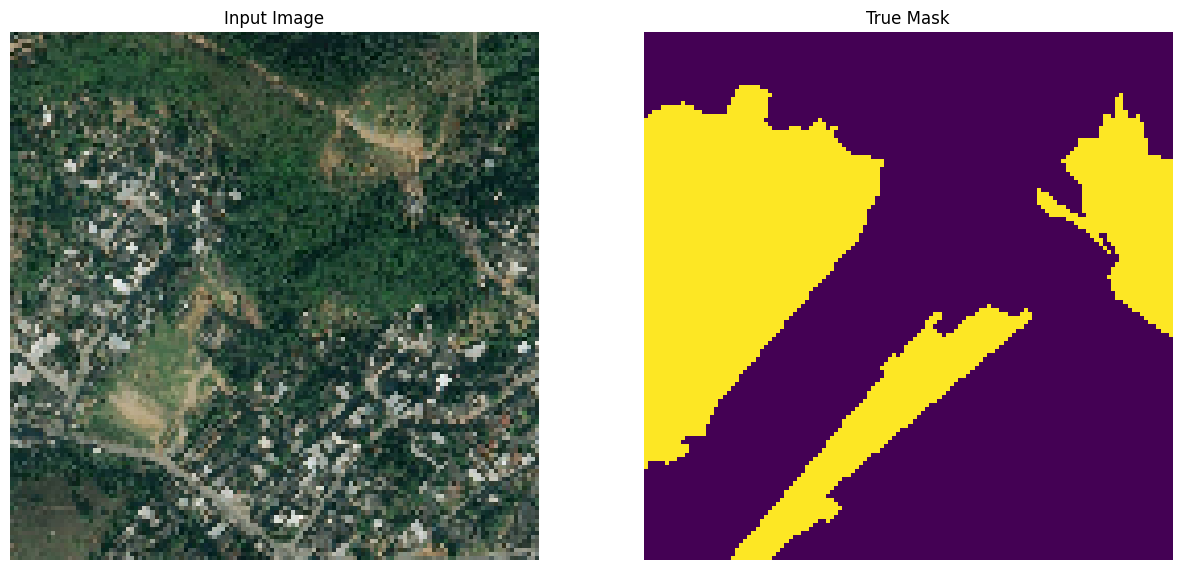

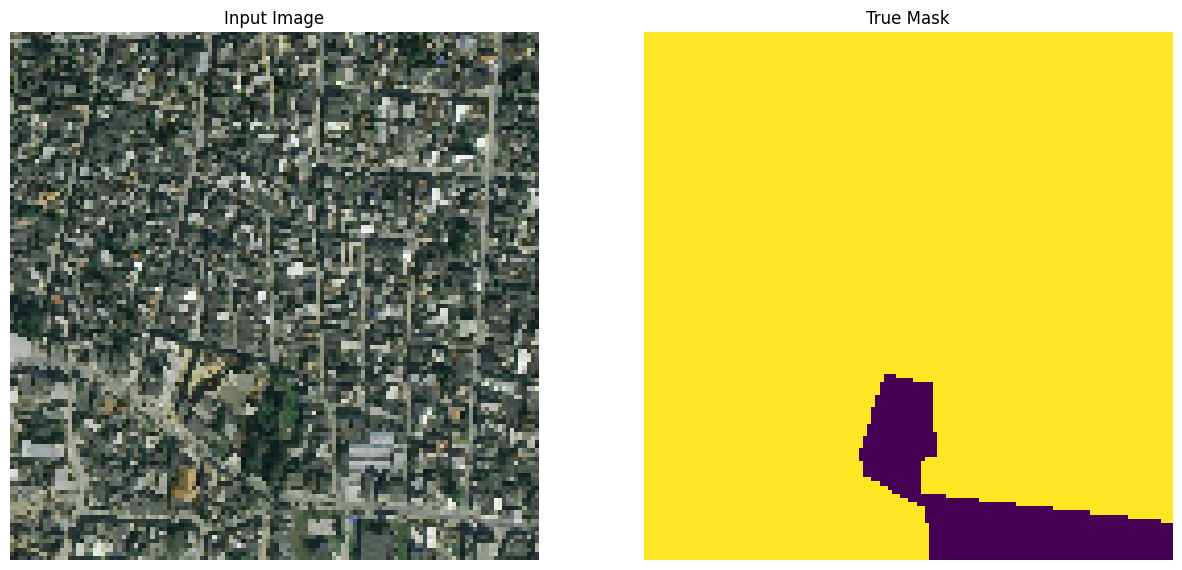

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

#   # 检查掩码中的唯一值
#   unique_values = tf.unique(tf.reshape(sample_mask, [-1])).y
#   print("Mask 中的唯一值:", unique_values.numpy())

In [ ]:
sample_image.shape
sample_mask.shape

TensorShape([128, 128, 1])

Training:


1. Unet
1.   ResUnet
2.   image segmentation from tensorflow sample


DCGAN

#### ResUnet-a
framework: tensorflow

source: https://github.com/yingkaisha/keras-unet-collection/tree/main

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

In [ ]:
!pip install keras-unet-collection

In [ ]:
!pip install tensorflow==2.12.0 keras==2.12.0

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras_unet_collection import models

print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

TensorFlow 2.12.0; Keras 2.12.0


In [ ]:
from keras_unet_collection import models

In [ ]:
model = models.resunet_a_2d((256, 256, 3), [32, 64, 128, 256, 512, 1024],
                            dilation_num=[1, 3, 15, 31],
                            n_labels=1, #revised
                            aspp_num_down=256, aspp_num_up=128,
                            activation='ReLU', output_activation='Sigmoid',
                            batch_norm=True, pool=False, unpool='nearest', name='resunet')

Received dilation rates: [1, 3, 15, 31]
Received dilation rates are not defined on a per downsampling level basis.
Automated determinations are applied with the following details:
	depth-0, dilation_rate = [1, 3, 15, 31]
	depth-1, dilation_rate = [1, 3, 15, 31]
	depth-2, dilation_rate = [1, 3, 15]
	depth-3, dilation_rate = [1, 3, 15]
	depth-4, dilation_rate = [1]
	depth-5, dilation_rate = [1]


todo:
- 更换数据集
- encoded weight

In [ ]:
model.layers[0].name

'input_1'

In [ ]:
# 创建日志目录
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # 监控验证损失
    patience=3,          # 如果验证损失在3个epoch内没有改善，则停止训练
    restore_best_weights=True  # 恢复训练过程中表现最好的模型权重
)

In [ ]:
# for Unet(from sm)
# model.compile(
#     'Adam',
#     loss=sm.losses.bce_jaccard_loss,
#     metrics=[sm.metrics.iou_score]
# )

#  for ResUnet-a
model.compile(
    # 'Adam',
    loss='binary_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=1e-2)
)

In [ ]:
model.fit(
   train_batches,
   epochs=15,
   validation_data=valid_batches,
   steps_per_epoch=STEPS_PER_EPOCH,  # Add steps_per_epoch
   callbacks=[tensorboard_callback, early_stopping_callback, checkpoint]
)

Epoch 1/15


为什么run不出来

<!-- BCE Jaccard Loss 是一个组合损失函数，它结合了两种损失：

BCE (Binary Cross Entropy) - 二元交叉熵损失：


用于衡量预测值与真实值之间的差异
适合二分类问题
计算公式：BCE = -(y*log(p) + (1-y)*log(1-p))

y 是真实值（0或1）
p 是预测值（0到1之间的概率）




Jaccard Loss - 基于 Jaccard 指数（也叫交并比 IoU）：


衡量两个集合的相似度
计算公式：Jaccard = |A∩B| / |A∪B|
Jaccard Loss = 1 - Jaccard Index -->

In [ ]:
%tensorboard --logdir=logs

#### Unet
framework: tensorflow

https://github.com/qubvel/segmentation_models

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

In [ ]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# load your data
# x_train, y_train, x_val, y_val = load_data(...)

# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(
    'Adam',
    loss='binary_crossentropy',
    # loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

model.summary()

#### Fine-tuned Unet


*   framework: Tensorflow
*   model: [Unet](https://www.tensorflow.org/tutorials/images/segmentation)



#### Define the model
The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the **encoder**. For the **decoder**, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo. (Check out the [pix2pix: Image-to-image translation with a conditional GAN](../generative/pix2pix.ipynb) tutorial in a notebook.)

这里使用的模型是经过修改的 U-Net。U-Net 由编码器（下采样器）和解码器（上采样器）组成。要学习稳健的特征并减少可训练参数的数量，请使用预训练模型 MobileNetV2 作为编码器。对于解码器，您将使用上采样块，该块已在 TensorFlow 示例存储库中的 pix2pix 示例中实现。（查看笔记本中的 pix2pix：使用条件 GAN 进行图像到图像转换教程。）


In [ ]:
# input size: 128*128

base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False


up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
# # input size: 640*640

# base_model = tf.keras.applications.MobileNetV2(input_shape=[640, 640, 3], include_top=False)

# # Use the activations of these layers
# layer_names = [
#     'block_1_expand_relu',   # 64x64
#     'block_3_expand_relu',   # 32x32
#     'block_6_expand_relu',   # 16x16
#     'block_13_expand_relu',  # 8x8
#     'block_16_project',      # 4x4
# ]
# base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# # Create the feature extraction model
# down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# down_stack.trainable = False


# up_stack = [
#     pix2pix.upsample(512, 3),  # 20x20 -> 40x40
#     pix2pix.upsample(256, 3),  # 40x40 -> 80x80
#     pix2pix.upsample(128, 3),  # 80x80 -> 160x160
#     pix2pix.upsample(64, 3),   # 160x160 -> 320x320
#     pix2pix.upsample(32, 3),   # 320x320 -> 640x640
# ] # revised

# def unet_model(output_channels:int):
#   inputs = tf.keras.layers.Input(shape=[640, 640, 3]) # revise

#   # Downsampling through the model
#   skips = down_stack(inputs)
#   x = skips[-1]
#   skips = reversed(skips[:-1])

#   # Upsampling and establishing the skip connections
#   for up, skip in zip(up_stack, skips):
#     x = up(x)
#     concat = tf.keras.layers.Concatenate()
#     x = concat([x, skip])

#   # This is the last layer of the model
#   last = tf.keras.layers.Conv2DTranspose(
#       filters=output_channels, kernel_size=3, strides=2,
#       padding='same')  # 320x320 -> 640x640

#   x = last(x)

#   return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
OUTPUT_CLASSES = 2 # change here

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

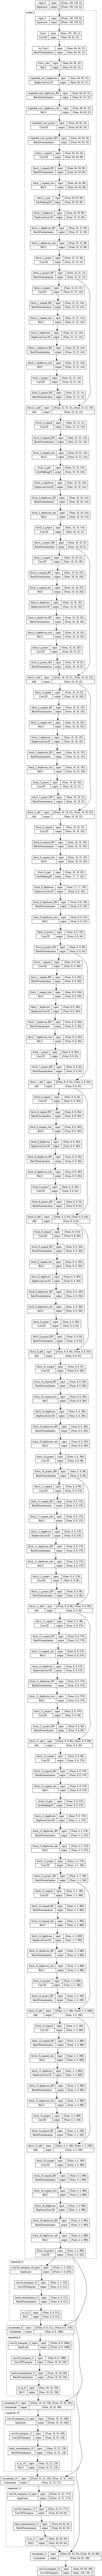

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])


1/1 [==============================] - 1s 1s/step


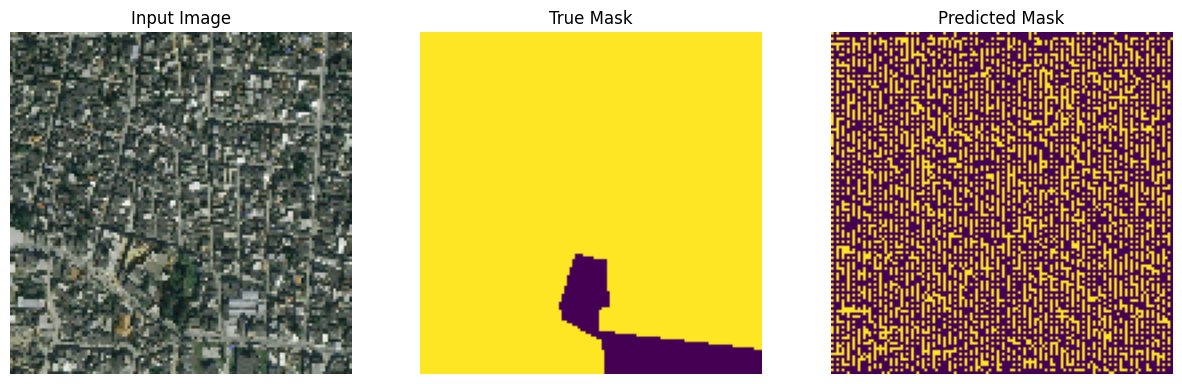

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 119ms/step


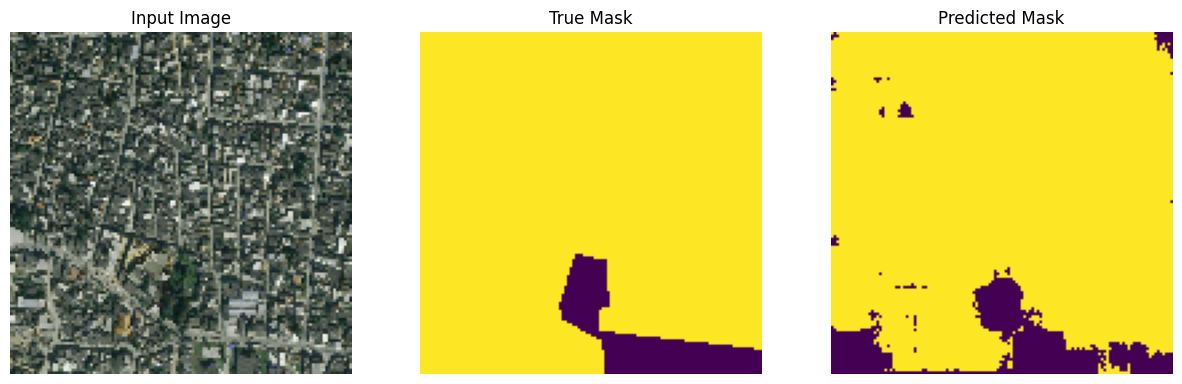


Sample Prediction after epoch 20

23/23 [==============================] - 153s 7s/step - loss: 0.1781 - accuracy: 0.9260


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = tf.data.experimental.cardinality(test_dataset).numpy()

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

真的很慢是为什么

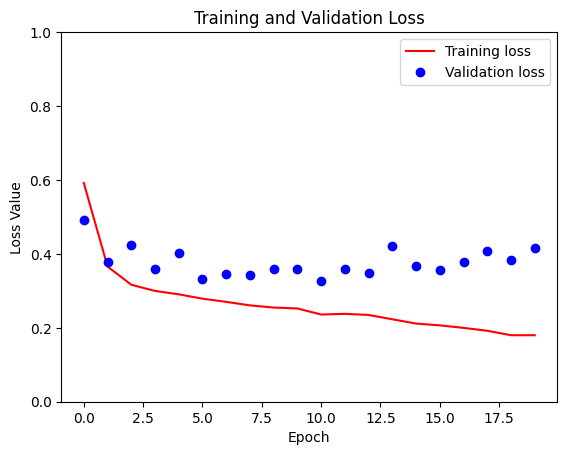

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

make prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


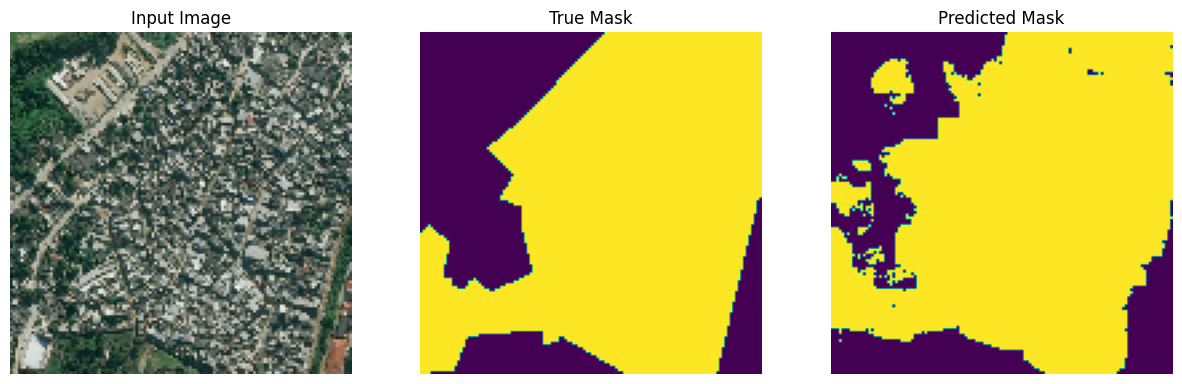

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


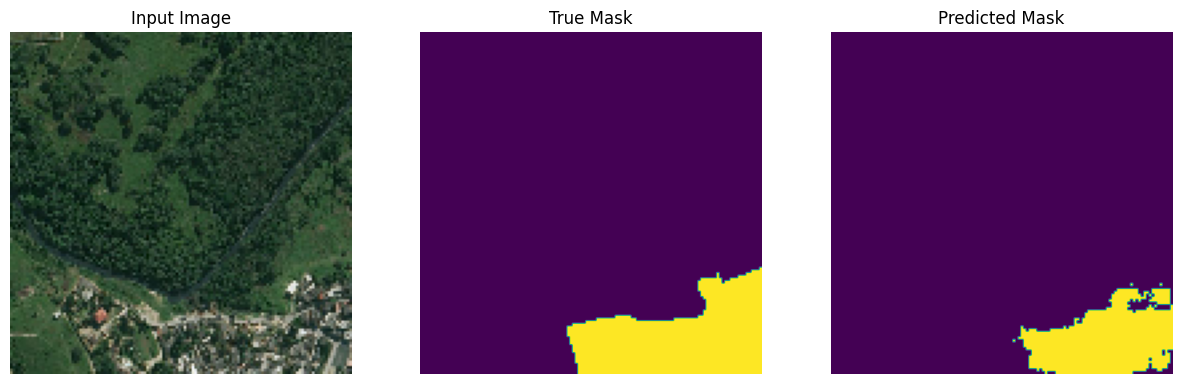

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
TEST_LENGTH = tf.data.experimental.cardinality(test_batches).numpy()
TEST_LENGTH


2

todo: 解决一下这个崩溃

图像大小超过128*128 内存溢出 很慢 train_batches感觉有点问题

- 图像大小
- evaluation拉到一个层面


#### ResUNet
*   framework: Tensorflow
*   model: [resunet](https://github.com/JanPalasek/resunet-tensorflow)



In [ ]:
!pip install git+https://github.com/JanPalasek/resunet-tensorflow
from resunet import ResUNet

  Cloning https://github.com/JanPalasek/resunet-tensorflow to /tmp/pip-req-build-lxzsw21b
  Running command git clone --filter=blob:none --quiet https://github.com/JanPalasek/resunet-tensorflow /tmp/pip-req-build-lxzsw21b
  Resolved https://github.com/JanPalasek/resunet-tensorflow to commit 9f080caba27441a16697818cb7064839c40223e5
  Preparing metadata (setup.py) ... done
  Created wheel for resunet: filename=resunet-1.1-py3-none-any.whl size=2819 sha256=31010f75decdc7c3d0bd6214797648b34a43bf0abd255ed072def618801111da
  Stored in directory: /tmp/pip-ephem-wheel-cache-b2m3aucf/wheels/c7/b7/86/e638494fd9e71404c082cadf60bf35d9a7241cdbb93a912671
Successfully built resunet


In [ ]:
# create model for inputs of sizes (128, 128, 1) for semantic segmentation into 2 classes
# architecture will have 16 filters in the root and the depth of 3 blocks
# model = ResUNet(input_shape=(512, 512, 3), classes=1, filters_root=16, depth=3)

model = ResUNet(input_shape=(128, 128, 3), classes=1, filters_root=16, depth=3)

# compile the model
# categorical crossentropy is the preferred loss function
# param ["categorical_crossentropy", "binary_crossentropy"]
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["binary_accuracy", MeanIoU(num_classes=2)])
# "binary_accuracy"

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)
# 为什么不行，报错

InvocationException: Program terminated with status: -6. stderr follows: newtrap: Trapezoid-table overflow 441
dot: trapezoid.c:84: newtrap: Assertion `0' failed.


In [ ]:
EPOCHS = 10  # 自定义训练轮数
BATCH_SIZE = 64  # 与 train_batches 中一致

history = model.fit(
    x=train_batches,
    validation_data=test_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # validation_steps=tf.data.experimental.cardinality(test_batches).numpy() // BATCH_SIZE  # 每个验证 epoch 的验证步数
)

Epoch 1/10


都说内存溢出

#### Unet,ResUnet++ official


*   framework: pytorch and tensorflow
*   model: [resunet++
](https://github.com/DebeshJha/ResUNetPlusPlus)


*   revised code: https://github.com/Emmmmmmaa/ResUNetPlusPlus




In [ ]:
!git clone https://github.com/Emmmmmmaa/ResUNetPlusPlus.git

Cloning into 'ResUNetPlusPlus'...
remote: Enumerating objects: 41565, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 41565 (delta 25), reused 13 (delta 13), pack-reused 41532 (from 3)
Receiving objects: 100% (41565/41565), 560.64 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (1082/1082), done.
Updating files: 100% (52023/52023), done.


In [ ]:
cd ResUNetPlusPlus/

/content/ResUNetPlusPlus


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
!python run.py

2025-01-09 01:39:01.477904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 01:39:01.496699: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 01:39:01.502595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 01:39:02.513585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1736386744.199804    1551 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

这个还是很慢呀